In [12]:
import torch
import torchvision
# import torchmetrics
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
# from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import random

from pathlib import Path
import zipfile
import requests
import os

from PIL import Image

In [ ]:
import data_setup, engine

> #### Defining the paths

In [13]:
data_path = Path('../data/')
image_path = data_path / 'pizza_steak_sushi'
image_paths_list = list(image_path.glob('*/*/*.jpg'))

train_path = image_path / 'train'
test_path = image_path / 'test'

> ### Transforms

> #### Manually created transforms
+ We want our custom data to be transformed in the same way as the data on which the model was trained on.<br><br>
+ We'll define the tranformations for our data ourselves.<br><br>
+ The images should be normalized like:
    + mini batches of 3-channels RGB images of shape [3 x H x W] where H and W are expected to be atleast 224.
    + the images have to be loaded in to a range of [0, 1]
    + the images have to be normalized using:
        + `mean=[0.485, 0.456, 0.406]`
        + `std=[0.229, 0.224, 0.225]`

In [15]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
])

In [76]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_path, test_path,
    transform=manual_transforms,
    batch_size=32)

> #### Automatic transformations

+ `DEFAULT` means best available weights.<br><br>
+ `DEFAULT` is same as `IMAGENET1K_V1`.<br><br>

In [114]:
torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [115]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_path, test_path,
    transform=torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms(),
    batch_size=32)

In [127]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

eff_net_model = torchvision.models.efficientnet_b0(weights=weights)

In [128]:
summary(model=eff_net_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "trainable", "num_params"],
        col_width=25,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable                 Param #
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 True                      --
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           True                      --
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         True                      --
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         True                      864
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         True                      64
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --


> Freezing the base layer

In [129]:
for param in eff_net_model.features.parameters():
    param.requires_grad = False

> Updating the classifier head

In [130]:
eff_net_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [131]:
eff_net_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True))

In [132]:
eff_net_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

> #### Training the feature extractor

In [133]:
EPOCHS = 5
BATCH_SIZE = 32
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eff_net_model.parameters(), lr=learning_rate)

In [134]:
model_results = engine.train(model=eff_net_model,
                             train_dataloader=train_dataloader,
                             test_dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             optimizer=optimizer,
                             epochs=EPOCHS)

Epoch: 1 | train_loss: 1.0369 | train_acc: 0.5859 |test_loss: 0.9272 | test_acc: 0.5805
Epoch: 2 | train_loss: 0.9264 | train_acc: 0.5977 |test_loss: 0.8180 | test_acc: 0.6307
Epoch: 3 | train_loss: 0.7614 | train_acc: 0.8516 |test_loss: 0.7161 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.6848 | train_acc: 0.7773 |test_loss: 0.6928 | test_acc: 0.7737
Epoch: 5 | train_loss: 0.6278 | train_acc: 0.8125 |test_loss: 0.5822 | test_acc: 0.8655


In [125]:
def plot_results(model_results):
    tr_loss = model_results['train_loss']
    ts_loss = model_results['test_loss']
    
    tr_accuracies = model_results['train_acc']
    ts_accuracies = model_results['test_acc']
    
    epochs = range(len(tr_accuracies))
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, label='train_loss')
    plt.plot(epochs, ts_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_accuracies, label='train_accuracy')
    plt.plot(epochs, ts_accuracies, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

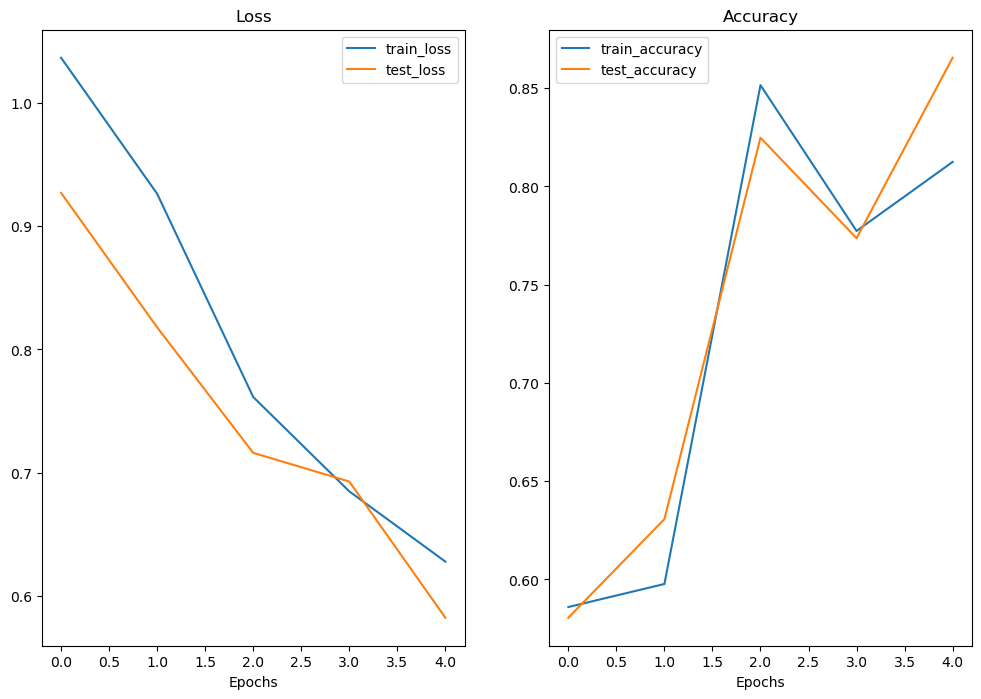

In [135]:
plot_results(model_results=model_results)

In [219]:
def make_predictions(model, data):
    prediction_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)
            raw_logits = model(sample)
            prediction_probs.append(torch.softmax(raw_logits.squeeze(), dim=0))
    return torch.argmax(torch.stack(prediction_probs), dim=1)

In [250]:
test_image_paths = list(image_path.glob('test/*/*.jpg'))

eval_images = [Image.open(image_path) for image_path in
               random.sample(test_image_paths, k = 16)]

In [251]:
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
])

transformed_images = [manual_transform(eval_image) for eval_image in eval_images]

In [ ]:
model_predictions = make_predictions(eff_net_model, transformed_images)

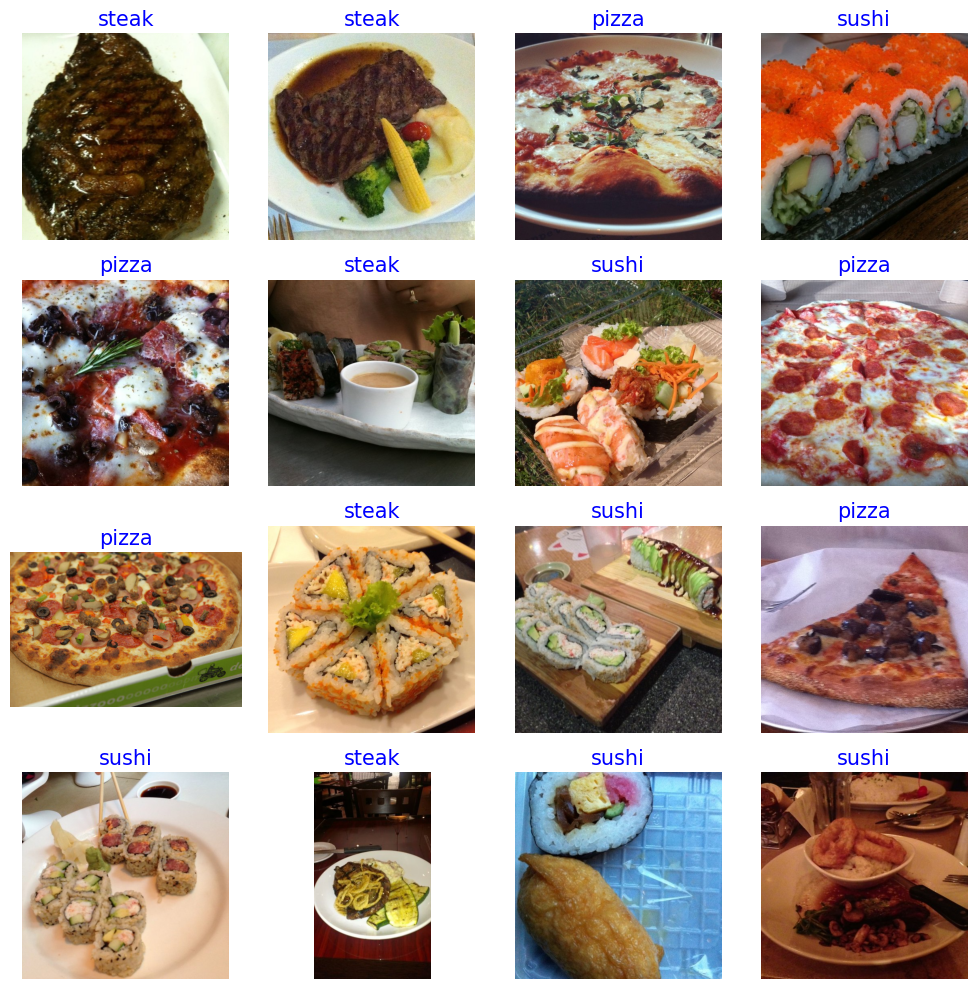

In [260]:
fig = plt.figure(figsize=(10, 10))
rows , cols = 4, 4

for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(eval_images[i - 1])
    plt.title(class_names[model_predictions[i - 1]], color='blue', fontsize=15)
    plt.axis('off')
plt.tight_layout()
plt.show()